In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import astropy.units as u
import astropy.constants as c

def rcparams_format(dic):
    dic['text.usetex'] = True
    dic['font.family'] = 'sans-serif'
    dic['font.sans-serif'] = ['Ariel']
    dic['font.size'] = 25
    dic['xtick.labelsize'] = 25
    dic['ytick.labelsize'] = 25
    dic['xtick.major.size'] = 6
    dic['ytick.major.size'] = 6
    dic['xtick.major.width'] = 1.6
    dic['ytick.major.width'] = 1.6
    dic['xtick.minor.size'] = 3
    dic['ytick.minor.size'] = 3
rcparams_format(mpl.rcParams)

## SEDs for SN 2004et and SN 2017eaw

In [2]:
# Flux [muJy] - Table 1 in Shahbandeh+2023
Fnu_04et = np.array([15.96, 122.63, 279.68, 456.39, 727.80, 1037.30, 1238.45, 1804.75])
Fnu_unc_04et = np.array([0.49, 1.51, 3.60, 4.36, 5.85, 6.42, 7.58, 21.60])
Fnu_17eaw = np.array([6.39, 58.12, 51.17, 43.30, 63.26, 117.00, 128.20, 102.47])
Fnu_unc_17eaw = np.array([0.29, 0.79, 1.25, 0.58, 0.69, 1.28, 1.61, 6.08])

## Meta data

In [3]:
# Distance
D = 7.12  # Mpc
# Heliocentric redshift
z = 0.00013
# Filters
flts = glob.glob('JWST_filters/*dat')
flts.sort()
flts_LSST = glob.glob('./LSST_filters/*dat')
flts_LSST.sort()
# Effective wavelengths
wvs_eff = np.array([55870.54, 98792.57, 112960.72, 127060.62,
                  149256.55, 178732.78, 205607.10, 251520.10])
wvs_eff_LSST = np.array([10056.62, 8695.51])
dlam_dnu = wvs_eff / (2.99792458e10 / (wvs_eff * 1e-8)) # Ang/Hz
Flam_04et = Fnu_04et / dlam_dnu * 1e-6 * 1e-23
Flam_unc_04et = Fnu_unc_04et / dlam_dnu * 1e-6 * 1e-23
Flam_17eaw = Fnu_17eaw / dlam_dnu * 1e-6 * 1e-23
Flam_unc_17eaw = Fnu_unc_17eaw / dlam_dnu * 1e-6 * 1e-23

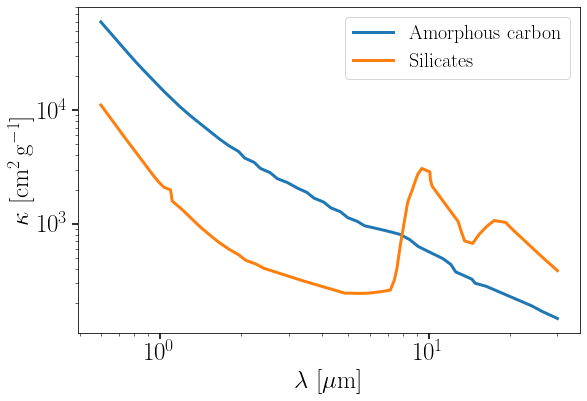

In [134]:
from scipy.interpolate import interp1d
wv_grid = np.arange(6000, 300000+25, step=25, dtype=np.float64)
L_wv = len(wv_grid)

kappa_C_Sarangi = np.loadtxt('C.csv', delimiter=',')
kappa_Si_Sarangi = np.loadtxt('Si.csv', delimiter=',')


kappa_C = 10**interp1d(x=kappa_C_Sarangi[:, 0], y=kappa_C_Sarangi[:, 1])(
    np.log10(wv_grid/1e4))
kappa_Si = 10**interp1d(x=kappa_Si_Sarangi[:, 0], y=kappa_Si_Sarangi[:, 1])(
    np.log10(wv_grid/1e4))

plt.figure(figsize=(9, 6))
plt.plot(wv_grid/1e4, kappa_C, linewidth=3, label=r'$\mathrm{Amorphous\ carbon}$')
plt.plot(wv_grid/1e4, kappa_Si, linewidth=3, label=r'$\mathrm{Silicates}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\lambda\ [\mu\mathrm{m}]$')
plt.ylabel(r'$\kappa\ [\mathrm{cm}^2\,\mathrm{g}^{-1}]$')
plt.legend(prop={'size': 20})

plt.savefig('kappa.pdf', bbox_inches='tight')

## Synthetic photometry

In [5]:
def spec_to_flux(spec, flt):
    '''
    get synthetic photometry from SED
    '''
    wv, fl = spec

    wv_flt, tra_flt = flt[:, 0], flt[:, 1]  # filter
    
    # if (wv_flt[9] < wv[0]) or (wv_flt[-10] > wv[-1]):
    #         return np.nan, np.nan
    tra_interp = np.interp(x=wv, xp=wv_flt, fp=tra_flt)
    tra_interp[(wv < wv_flt[0]) | (wv > wv_flt[-1])] = 0
    
    # effective bandwidth
    dlambda = np.diff(wv)
    width = (dlambda * tra_interp[1:] * wv[1:]).sum()
    # convolution
    weight = tra_interp[1:] * wv[1:] / width * dlambda
    flux = (fl[1:] * weight).sum()  # erg cm-2 s-1 AA-1
    return flux

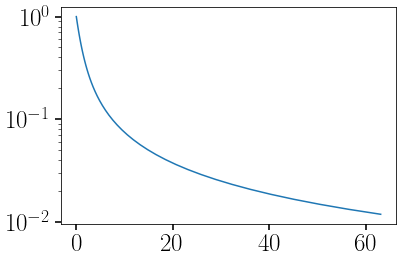

In [6]:
def B_lam(lam, T):
    hc = (1 * c.h * c.c**2 / u.AA**5).to('erg*cm**-2*s**-1*AA**-1').value
    hc_k = (1 * c.h * c.c / u.AA / c.k_B / u.Kelvin).cgs.value
    return 2 * hc / lam**5 / (np.exp(hc_k / lam / T) - 1)


def P_esc(tau):
    return 3/(4 * tau) * (1 - 1/(2 * tau**2) + (1/tau + 1/(2 * tau**2)) * np.exp(-2 * tau))

plt.plot(np.logspace(-3, 1.8, 100), P_esc(np.logspace(-3, 1.8, 100)))
plt.yscale('log')

## Models

In [7]:
import pymc as pm
import arviz as az
import corner

In [76]:
def single_T_model(kappa, Flam, Flam_unc, plot_graphviz=False):
    with pm.Model() as single_T:
        log_T = pm.Uniform('log_T', 1, 4)
        T = pm.Deterministic('T', 10**log_T)
        log_Mdust = pm.Normal('log_Mdust', -2, 1)
        Mdust = pm.Deterministic('Mdust', 10**log_Mdust)

        D = pm.Normal('D', 7.12, 0.1)
        Msun = (1*u.Msun/u.g).cgs.value
        Mpc = (1*u.Mpc/u.cm).cgs.value
        F = pm.Deterministic('F', B_lam(wv_grid, T) *
                             (Mdust * Msun) * kappa / (D * Mpc)**2)
        flams = []
        for k in range(len(Flam)):
            flt = np.loadtxt(flts[k])
            flams.append(pm.Deterministic(
                f'JWST_f_{k}', spec_to_flux(spec=[wv_grid, F], flt=flt)))
        pm.Normal('obs', flams, Flam_unc, observed=Flam)

    if plot_graphviz:
        return (pm.model_to_graphviz(single_T))
    else:
        with single_T:
            trace = pm.sample(return_inferencedata=True)

        return trace


def double_T_model(kappa, Flam, Flam_unc,
                   T_thres=500, T1_mu=-1, T1_sig=-1, T2_mu=-1, T2_sig=-1,
                   fix_tau=True,
                   log_R_mu=None,
                   plot_graphviz=False, 
                   n_tune=1000):
    with pm.Model() as double_T:
        if T1_mu < 0:
            log_T1 = pm.Uniform('log_T1', 2, np.log10(T_thres))
            T1 = pm.Deterministic('T1', 10**log_T1)
        else:
            T1 = pm.Normal('T1', T1_mu, T1_sig)
        if T2_mu < 0:
            log_T2 = pm.Uniform('log_T2', np.log10(T_thres), 4)
            T2 = pm.Deterministic('T2', 10**log_T2)
        else:
            T2 = pm.TruncatedNormal('T2', T2_mu, T2_sig, lower=T_thres)

        log_Mdust1 = pm.TruncatedNormal('log_Mdust1', -2, 1, upper=1)
        Mdust1 = pm.Deterministic('Mdust1', 10**log_Mdust1)
        log_Mdust2 = pm.TruncatedNormal('log_Mdust2', -4, 1, upper=1)
        Mdust2 = pm.Deterministic('Mdust2', 10**log_Mdust2)
        Mdust = pm.Deterministic('Mdust', Mdust1 + Mdust2)

        D = pm.Normal('D', 7.12, 0.1)
        Msun = (1*u.Msun/u.g).cgs.value
        Mpc = (1*u.Mpc/u.cm).cgs.value
        if fix_tau:
            F = pm.Deterministic('F', (B_lam(wv_grid, T1) * Mdust1 +
                                       B_lam(wv_grid, T2) * Mdust2) * Msun * kappa / (D * Mpc)**2)
        else:
            log_R = pm.Normal('log_R', log_R_mu, 0.2)
            R = pm.Deterministic('R', 10**log_R)
            tau = pm.Deterministic(
                'tau', 3/4/np.pi * Mdust * Msun / R**2 * kappa)
            F = pm.Deterministic('F', (B_lam(wv_grid, T1) * Mdust1 +
                                       B_lam(wv_grid, T2) * Mdust2) * Msun * kappa / (D * Mpc)**2 * P_esc(tau))
        flams = []
        for k in range(len(Flam)):
            flt = np.loadtxt(flts[k])
            flams.append(pm.Deterministic(
                f'JWST_f_{k}', spec_to_flux(spec=[wv_grid, F], flt=flt)))
        pm.Normal('obs', flams, Flam_unc, observed=Flam)

    if plot_graphviz:
        return (pm.model_to_graphviz(double_T))
    else:
        with double_T:
            trace = pm.sample(return_inferencedata=True, tune=n_tune)

        return trace


In [131]:
def plot_model(trace, Flam, Flam_unc):
    summary = az.summary(trace, hdi_prob=0.68, var_names=[
                         f'JWST_f_{k}' for k in range(len(wvs_eff))], round_to=25)
    plt.figure(figsize=(9, 6))
    plt.plot(
        wv_grid/1e4, trace.posterior['F'].values.reshape(4 * 1000, L_wv)[::10].T/1e-18, color='0.3', alpha=.1, linewidth=.3)
    plt.errorbar(
        wvs_eff/1e4,
        summary['mean']/1e-18,
        yerr=np.array([summary['hdi_84%'] - summary['mean'],
                       summary['mean'] - summary['hdi_16%']])/1e-18,
        color='k', fmt='v', label=r'$\mathrm{Model}$', ms=10,
        mfc='white', mew=2.5)
    for k in range(len(wvs_eff)):
        flt = np.loadtxt(flts[k])
        plt.plot(flt[:, 0]/1e4, flt[:, 1] * Flam.max()/1e-18, color='0.8')
    plt.errorbar(wvs_eff/1e4, Flam/1e-18, yerr=Flam_unc/1e-18,
                 label=r'$\mathrm{Obs\ (JWST)}$', color='crimson', fmt='o', ms=10)

    plt.legend(prop={'size': 20})

    plt.ylabel(
        '$F_\lambda\ [10^{-18}\,\mathrm{erg}\,\mathrm{s}\,\mathrm{cm}^{-2}\,\mathrm{\AA}^{-1}]$')
    plt.xlabel('$\lambda\ [\mu\mathrm{m}]$')
    return plt.gca()


def plot_Fnu(trace, Flam, Flam_unc, plot_prediction=False):
    summary = az.summary(trace, hdi_prob=0.68, var_names=[
                         f'JWST_f_{k}' for k in range(len(wvs_eff))], round_to=25)

    dlam_dnu0 = wv_grid / (2.99792458e10 / (wv_grid * 1e-8))  # Ang/Hz
    plt.figure(figsize=(9, 9))
    plt.plot(
        wv_grid/dlam_dnu0,
        np.multiply(np.atleast_2d(dlam_dnu0).T,
                    trace.posterior['F'].values.reshape(4 * 1000, L_wv)[::10].T) * 1e23 * 1e6,
        color='0.3',
        alpha=.1,
        linewidth=.3)
    plt.errorbar(
        wvs_eff/dlam_dnu,
        summary['mean'] * dlam_dnu * 1e23 * 1e6,
        yerr=np.array([summary['hdi_84%'] - summary['mean'],
                       summary['mean'] - summary['hdi_16%']]) * dlam_dnu * 1e23 * 1e6,
        color='k', fmt='v', label=r'$\mathrm{Model}$', ms=10,
        mfc='white', mew=2.5)
    plt.errorbar(wvs_eff/dlam_dnu, Flam * dlam_dnu * 1e23 * 1e6, yerr=Flam_unc * dlam_dnu * 1e23 * 1e6,
                 label=r'$\mathrm{Obs\ (JWST})$', color='crimson', fmt='o', ms=10)
    if plot_prediction:
        dlam_dnu0 = wvs_eff_LSST / \
            (2.99792458e10 / (wvs_eff_LSST * 1e-8))  # Ang/Hz
        Flam = trace.posterior['F'].values.reshape(
            4 * 1000, L_wv)[::10].T
        Flux_LSST, Flux_lo_LSST, Flux_up_LSST = np.empty(
            2), np.empty(2), np.empty(2)
        for k in range(len(wvs_eff_LSST)):
            flt = np.loadtxt(flts_LSST[k])
            flt[:, 0] = flt[:, 0] * 10
            Flux = []
            for i in range(len(Flam[0, :])):
                flux = spec_to_flux([wv_grid, Flam[:, i]], flt)
                Flux.append(flux)
            Flux_LSST[k] = np.mean(Flux)
            Flux_lo_LSST[k] = np.percentile(Flux, 16)
            Flux_up_LSST[k] = np.percentile(Flux, 84)
            print('yz'[k])
            print(-2.5*np.log10(Flux_LSST[k] * dlam_dnu0[k] * 1e23 / 3631))
            print(-2.5*np.log10(Flux_lo_LSST[k] * dlam_dnu0[k] * 1e23 / 3631))
            print(-2.5*np.log10(Flux_up_LSST[k] * dlam_dnu0[k] * 1e23 / 3631))
        plt.errorbar(
            wvs_eff_LSST/dlam_dnu0,
            Flux_LSST * dlam_dnu0 * 1e23 * 1e6,
            yerr=np.array([Flux_up_LSST[k] - Flux_LSST[k],
                          Flux_LSST[k] - Flux_lo_LSST[k]]) * dlam_dnu0 * 1e23 * 1e6,
            color='cornflowerblue',
            fmt='^',
            label=r'$\mathrm{Pred\ (LSST)}$',
            mfc='white', mew=2.5,
            ms=10,
            capsize=5)

    plt.legend(prop={'size': 20})

    plt.ylabel(r'$F_\nu\ [\mu\mathrm{Jy}]$')
    plt.xlabel(r'$\nu\ [\mathrm{Hz}]$')
    return plt.gca()


## SN 2004et

### Single temperature component

#### C

In [10]:
trace_04et_C_s = single_T_model(kappa_C, Flam_04et, Flam_unc_04et)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The acceptance probability does not match the target. It is 0.8934, but should be close to 0.8. Try to increase the number of tuning steps.


In [92]:
summary_04et_C_s = az.summary(trace_04et_C_s, hdi_prob=0.68, var_names=['D', 'T', 'log_Mdust'])
summary_04et_C_s

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.122,0.100,7.013,7.210,0.003,0.002,1255.0,1277.0,1.0
T,137.672,0.267,137.430,137.949,0.007,0.005,1627.0,1516.0,1.0
log_Mdust,-1.295,0.013,-1.309,-1.282,0.000,0.000,1202.0,1131.0,1.0


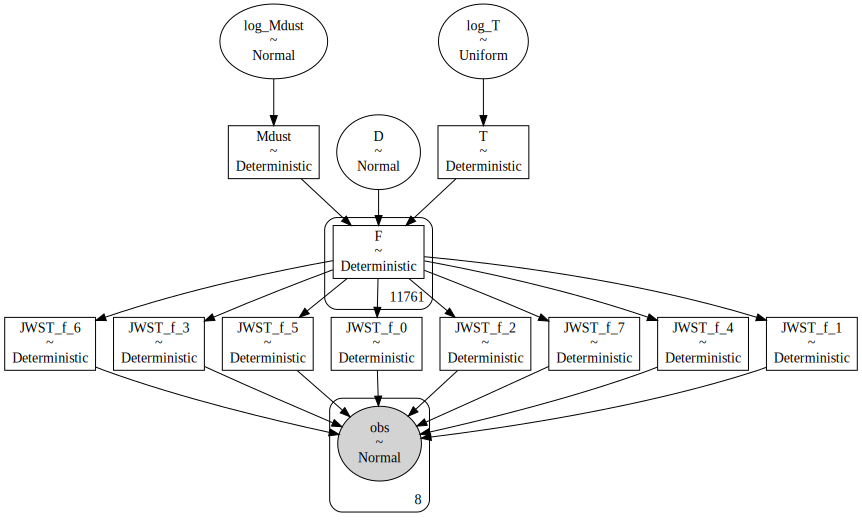

In [12]:
gv = single_T_model(kappa_C, Flam_04et, Flam_unc_04et, plot_graphviz=True)
# gv.render(filename='single_T')
gv

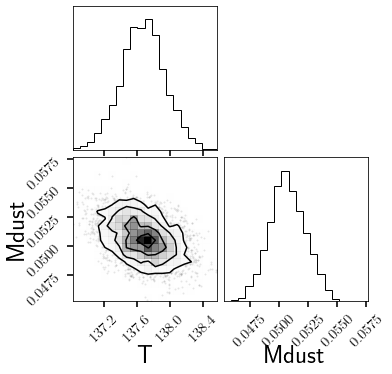

In [13]:
fig = corner.corner(trace_04et_C_s, var_names=['T', 'Mdust'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

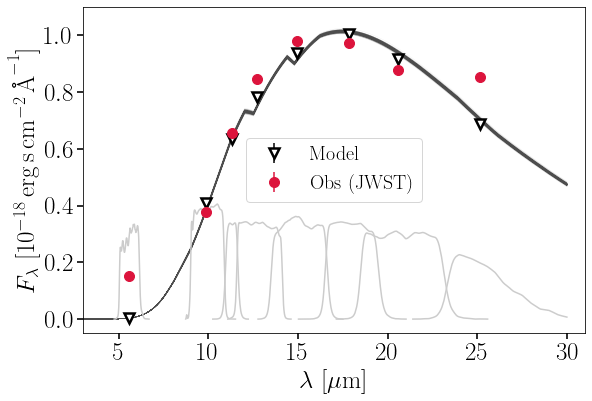

In [14]:
ax = plot_model(trace_04et_C_s, Flam_04et, Flam_unc_04et)
ax.set_xlim(3, 31)
ax.set_ylim(-0.05, 1.1)
plt.savefig('04et_singleT.pdf', bbox_inches='tight')

#### Si

In [16]:
trace_04et_Si_s = single_T_model(kappa_Si, Flam_04et, Flam_unc_04et)
summary_04et_Si_s = az.summary(trace_04et_Si_s, hdi_prob=0.68, var_names=['D', 'T', 'Mdust'], round_to=10)
summary_04et_Si_s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The acceptance probability does not match the target. It is 0.8791, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.119,0.099,7.037,7.235,0.003,0.002,1150.0,1276.0,1.0
T,138.886,0.243,138.663,139.126,0.006,0.004,1713.0,1566.0,1.0
Mdust,0.013,0.000,0.012,0.013,0.000,0.000,1175.0,1282.0,1.0


In [66]:
summary_04et_Si_s = az.summary(trace_04et_Si_s, hdi_prob=0.68, var_names=['D', 'T', 'Mdust'], round_to=10)
summary_04et_Si_s

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.119040,0.099063,7.037207,7.234835,0.002924,0.002068,1149.717703,1275.532549,1.001643
T,138.885863,0.243045,138.663084,139.125656,0.005868,0.004150,1712.897952,1565.671662,1.002443
Mdust,0.012860,0.000387,0.012460,0.013237,0.000011,0.000008,1175.090288,1281.998670,1.001769


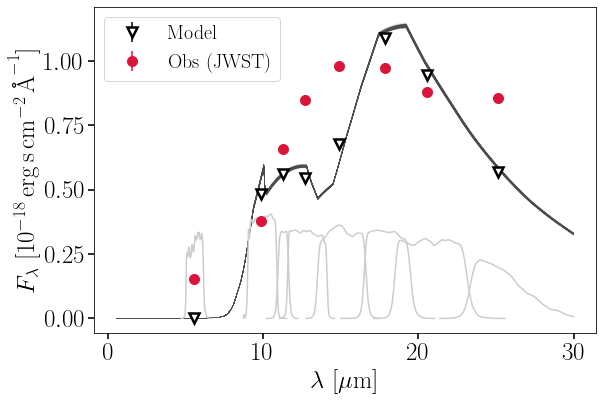

In [17]:
_ = plot_model(trace_04et_Si_s, Flam_04et, Flam_unc_04et)

### Double temperature components

In [85]:
trace_04et_C_d = double_T_model(kappa_C, Flam_04et, Flam_unc_04et, T2_mu=1500, T2_sig=500, T_thres=500)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


In [103]:
summary_04et_C_d = az.summary(trace_04et_C_d, hdi_prob=0.68, var_names=['D', 'T1', 'T2', 'log_Mdust1', 'log_Mdust2', 'Mdust'])
summary_04et_C_d

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.125,0.098,7.025,7.216,0.002,0.001,2194.0,2082.0,1.0
T1,136.927,0.263,136.697,137.197,0.005,0.004,2343.0,1730.0,1.0
T2,1879.188,380.339,1466.062,2221.117,9.545,6.751,1529.0,1280.0,1.0
log_Mdust1,-1.281,0.013,-1.294,-1.268,0.000,0.000,2106.0,1919.0,1.0
log_Mdust2,-7.287,0.172,-7.485,-7.161,0.005,0.003,1510.0,1242.0,1.0
Mdust,0.052,0.002,0.051,0.054,0.000,0.000,2106.0,1919.0,1.0


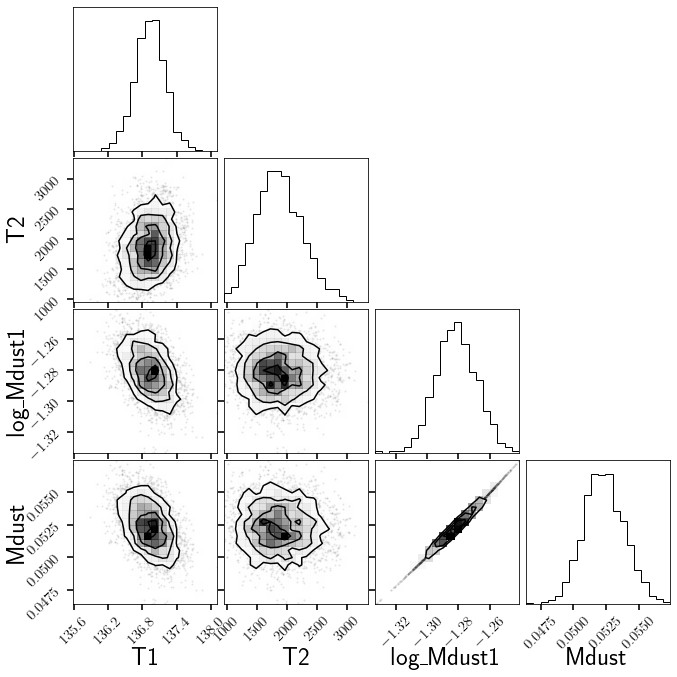

In [89]:
fig = corner.corner(trace_04et_C_d, var_names=['T1', 'T2', 'log_Mdust1', 'Mdust'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

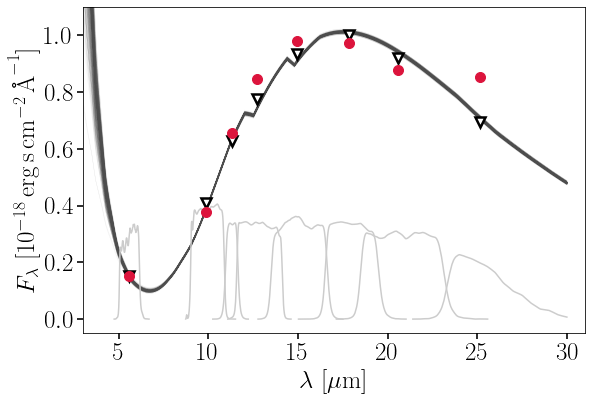

In [90]:
ax = plot_model(trace_04et_C_d, Flam_04et, Flam_unc_04et)
ax.set_xlim(3, 31)
ax.set_ylim(-0.05, 1.1)
ax.get_legend().remove()
plt.savefig('04et_doubleT.pdf', bbox_inches='tight')

### Double temperature components, non-negligible $\tau$

In [77]:
trace_04et_C_d_tau = double_T_model(kappa_C, Flam_04et, Flam_unc_04et,
                                    T2_mu=1500, T2_sig=500, T_thres=500,
                                    fix_tau=False, log_R_mu=np.log10(3e17), n_tune=2000)

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 675 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.56, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8927, but should be close to 0.8. Try to increase the number of tuning steps.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2958, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R,5.434100e+16,7.577546e+14,5.358375e+16,5.497366e+16,3.773908e+13,2.670489e+13,384.676203,476.221130,1.057145
T1,1.665291e+02,5.392130e-01,1.658291e+02,1.669481e+02,1.586225e-01,1.152575e-01,13.642798,85.249671,1.205223
T2,2.233760e+03,3.663355e+02,1.936689e+03,2.625613e+03,5.786337e+01,4.121706e+01,42.821878,555.539802,1.066782
Mdust,1.440008e+00,1.714567e+00,1.426747e-01,1.364180e+00,1.967330e-01,1.396489e-01,17.714853,51.517307,1.150184


In [84]:
summary_04et_C_d_tau = az.summary(trace_04et_C_d_tau, hdi_prob=0.68,
                                  var_names=['R', 'T1', 'T2', 'log_Mdust1', 'log_Mdust2'], round_to=10)
summary_04et_C_d_tau

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R,5.434100e+16,7.577546e+14,5.358375e+16,5.497366e+16,3.773908e+13,2.670489e+13,384.676203,476.221130,1.057145
T1,1.665291e+02,5.392130e-01,1.658291e+02,1.669481e+02,1.586225e-01,1.152575e-01,13.642798,85.249671,1.205223
T2,2.233760e+03,3.663355e+02,1.936689e+03,2.625613e+03,5.786337e+01,4.121706e+01,42.821878,555.539802,1.066782
log_Mdust1,-7.179423e-02,4.418548e-01,-7.109959e-01,2.168232e-01,1.049687e-01,7.548131e-02,17.714899,51.517307,1.150183
log_Mdust2,-5.188271e+00,4.823358e-01,-5.905024e+00,-4.861381e+00,1.249491e-01,9.325028e-02,15.722437,42.073080,1.171206


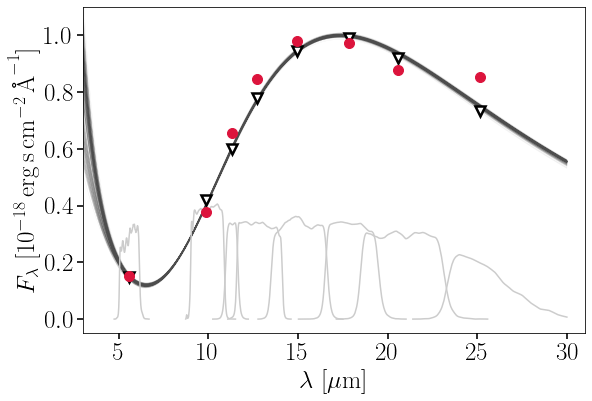

In [71]:
ax = plot_model(trace_04et_C_d_tau, Flam_04et, Flam_unc_04et)
ax.set_xlim(3, 31)
ax.set_ylim(-0.05, 1.1)
ax.get_legend().remove()
plt.savefig('04et_doubleT_tau.pdf', bbox_inches='tight')

y
21.31698339555384
22.48434915005888
20.82461697343543
z
21.82257424104671
23.28907160732319
21.289377243360708


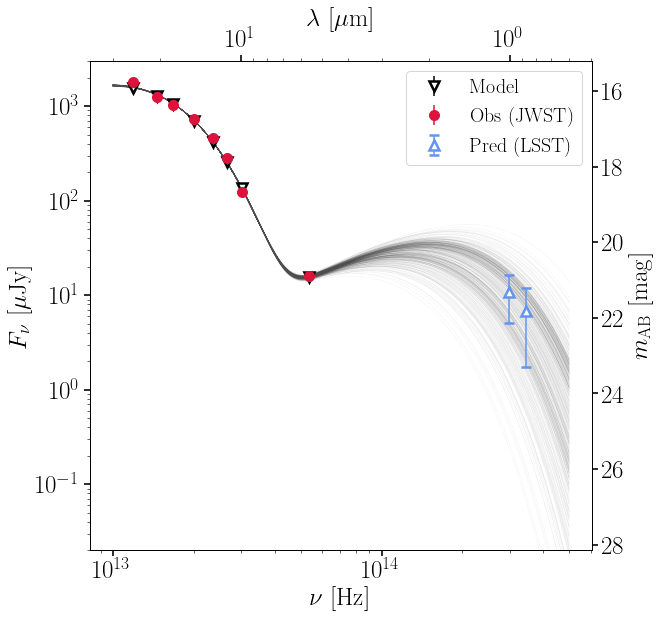

In [132]:
ax = plot_Fnu(trace_04et_C_d_tau, Flam_04et, Flam_unc_04et, plot_prediction=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(2e-2, 3e3)

ax_mag = ax.twinx()
ax_mag.set_ylim(-2.5*np.log10(np.array(ax.get_ylim())*1e-6/3631))
ax_mag.set_ylabel(r'$m_\mathrm{AB}\ [\mathrm{mag}]$')

ax_lam = ax.twiny()
ax_lam.set_xlim(2.99792458e10 / np.array(ax.get_xlim()) * 1e4)
ax_lam.set_xlabel(r'$\lambda\ [\mu\mathrm{m}]$')
ax_lam.set_xscale('log')

plt.savefig('04et_pred_tau.pdf', bbox_inches='tight')

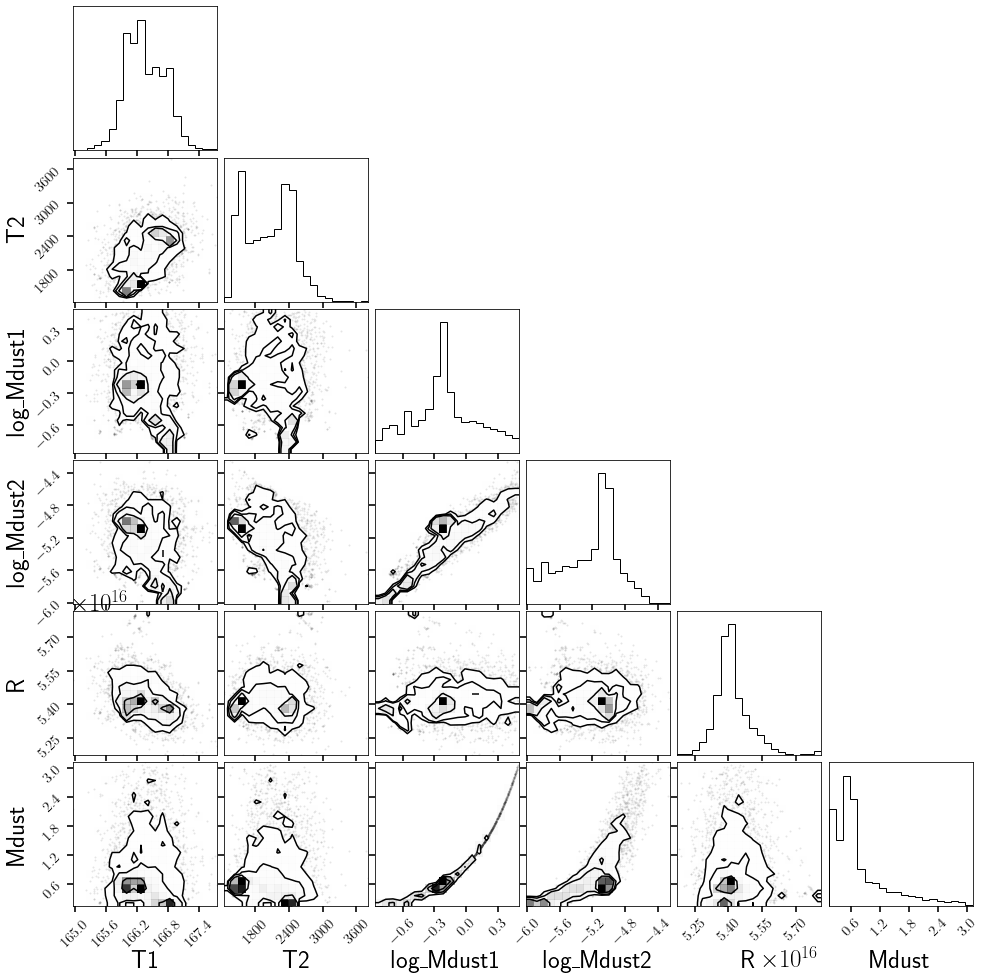

In [73]:
fig = corner.corner(trace_04et_C_d_tau, var_names=['T1', 'T2', 'log_Mdust1', 'log_Mdust2', 'R', 'Mdust'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

## SN 2017eaw

### Single temperature component

In [39]:
trace_17eaw_Si_s = single_T_model(kappa_Si, Flam_17eaw, Flam_unc_17eaw)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.118604,0.098141,7.024120,7.220810,2.441728e-03,1.726875e-03,1620.311455,1604.667774,1.000804
T,182.174653,0.838092,181.295778,182.962444,2.113932e-02,1.495531e-02,1577.227926,1698.742257,1.002454
Mdust,0.000327,0.000012,0.000314,0.000338,3.307000e-07,2.339000e-07,1334.806498,1590.523242,1.002242


In [93]:
summary_17eaw_Si_s = az.summary(trace_17eaw_Si_s, hdi_prob=0.68, var_names=['D', 'T', 'log_Mdust'], round_to=10)
summary_17eaw_Si_s

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.118604,0.098141,7.024120,7.220810,0.002442,0.001727,1620.311455,1604.667774,1.000804
T,182.174653,0.838092,181.295778,182.962444,0.021139,0.014955,1577.227926,1698.742257,1.002454
log_Mdust,-3.485336,0.016012,-3.500111,-3.468155,0.000441,0.000312,1334.806498,1590.523242,1.002302


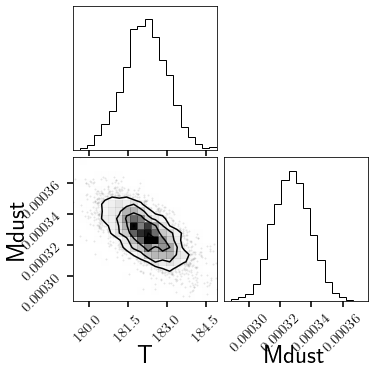

In [40]:
fig = corner.corner(trace_17eaw_Si_s, var_names=['T', 'Mdust'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

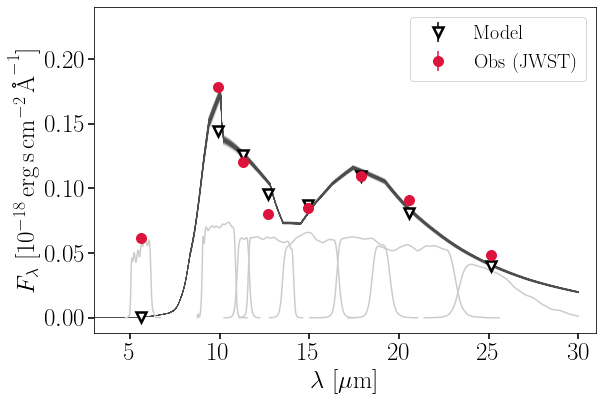

In [41]:
ax = plot_model(trace_17eaw_Si_s, Flam_17eaw, Flam_unc_17eaw)
ax.set_xlim(3, 31)
ax.set_ylim(-0.012, 0.24)
# ax.get_legend().remove()
plt.savefig('17eaw_singleT.pdf', bbox_inches='tight')

### Double temperature components

In [52]:
trace_17eaw_Si_d = double_T_model(kappa_Si, Flam_17eaw, Flam_unc_17eaw, T2_mu=1500, T2_sig=500, T_thres=500)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.126178,0.098572,7.032624,7.226853,0.002426,1.715939e-03,1649.385091,1752.097048,1.001501
T1,152.809071,1.442441,151.349264,154.141432,0.040494,2.863990e-02,1275.545692,1417.154708,1.002018
T2,1505.707553,174.896500,1306.111432,1632.051942,4.701529,3.325184e+00,1364.682145,1907.345180,1.001407
Mdust,0.000755,0.000043,0.000706,0.000789,0.000001,8.905000e-07,1153.228771,1509.104417,1.002870


In [94]:
summary_17eaw_Si_d = az.summary(trace_17eaw_Si_d, hdi_prob=0.68, var_names=['D', 'T1', 'T2', 'log_Mdust1'], round_to=10)
summary_17eaw_Si_d

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,7.126178,0.098572,7.032624,7.226853,0.002426,0.001716,1649.385091,1752.097048,1.001501
T1,152.809071,1.442441,151.349264,154.141432,0.040494,0.028640,1275.545692,1417.154708,1.002018
T2,1505.707553,174.896500,1306.111432,1632.051942,4.701529,3.325184,1364.682145,1907.345180,1.001407
log_Mdust1,-3.122963,0.024584,-3.148787,-3.100314,0.000724,0.000512,1153.459765,1509.104417,1.002866


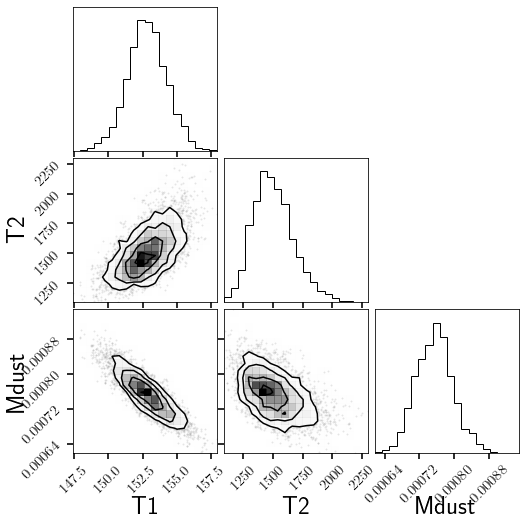

In [53]:
fig = corner.corner(trace_17eaw_Si_d, var_names=['T1', 'T2', 'Mdust'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

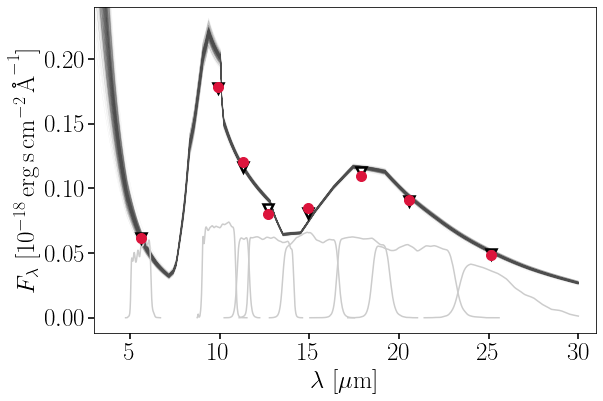

In [54]:
ax = plot_model(trace_17eaw_Si_d, Flam_17eaw, Flam_unc_17eaw)
ax.set_xlim(3, 31)
ax.set_ylim(-0.012, 0.24)
ax.get_legend().remove()
plt.savefig('17eaw_doubleT.pdf', bbox_inches='tight')

### Double temperature components, non-negligible $\tau$

In [56]:
trace_17eaw_Si_d_tau = double_T_model(kappa_Si, Flam_17eaw, Flam_unc_17eaw,
                                    T2_mu=1500, T2_sig=500, T_thres=500, fix_tau=False, log_R_mu=np.log10(8e16))


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 255 seconds.


In [95]:
summary_17eaw_Si_d_tau = az.summary(trace_17eaw_Si_d_tau, hdi_prob=0.68, var_names=[
                                  'R', 'T1', 'T2', 'log_Mdust1'], round_to=10)
summary_17eaw_Si_d_tau

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R,1.021577e+17,3.519406e+16,6.296046e+16,1.136504e+17,1.059589e+15,7.494407e+14,905.033838,1530.140264,1.004990
T1,1.508803e+02,1.981786e+00,1.492188e+02,1.530335e+02,6.953131e-02,4.918372e-02,854.950434,875.529209,1.004236
T2,1.197259e+03,1.806365e+02,9.861390e+02,1.325715e+03,6.340167e+00,4.484787e+00,754.633452,915.593208,1.006799
log_Mdust1,-3.084955e+00,3.626165e-02,-3.122327e+00,-3.053696e+00,1.301382e-03,9.205620e-04,825.873246,912.577764,1.005807


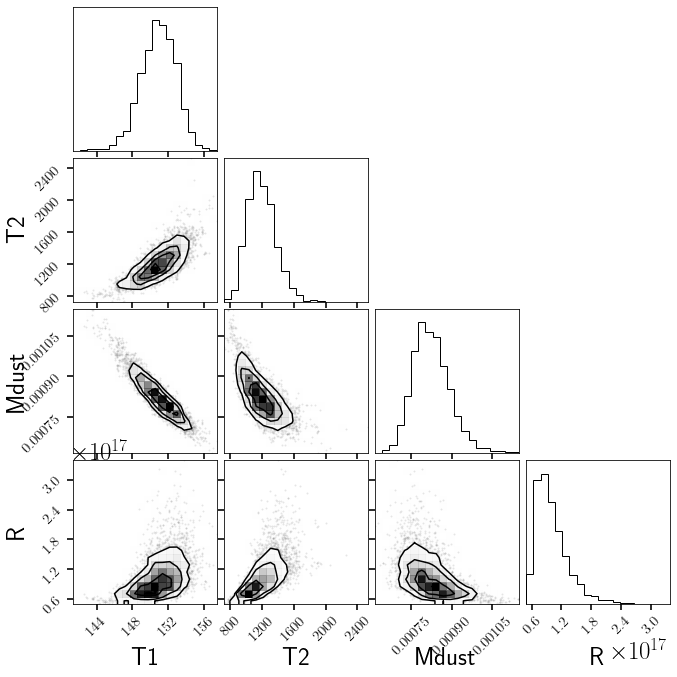

In [58]:
fig = corner.corner(trace_17eaw_Si_d_tau, var_names=['T1', 'T2', 'Mdust', 'R'])
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 15)

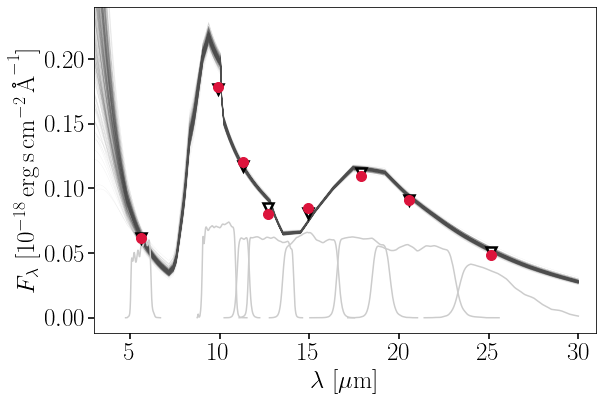

In [59]:
ax = plot_model(trace_17eaw_Si_d_tau, Flam_17eaw, Flam_unc_17eaw)
ax.set_xlim(3, 31)
ax.set_ylim(-0.012, 0.24)
ax.get_legend().remove()
plt.savefig('17eaw_doubleT_tau.pdf', bbox_inches='tight')

y
23.794678618286316
26.51820642852875
23.28339107200418
z
24.54418161274743
28.033840068293323
24.120043068324826


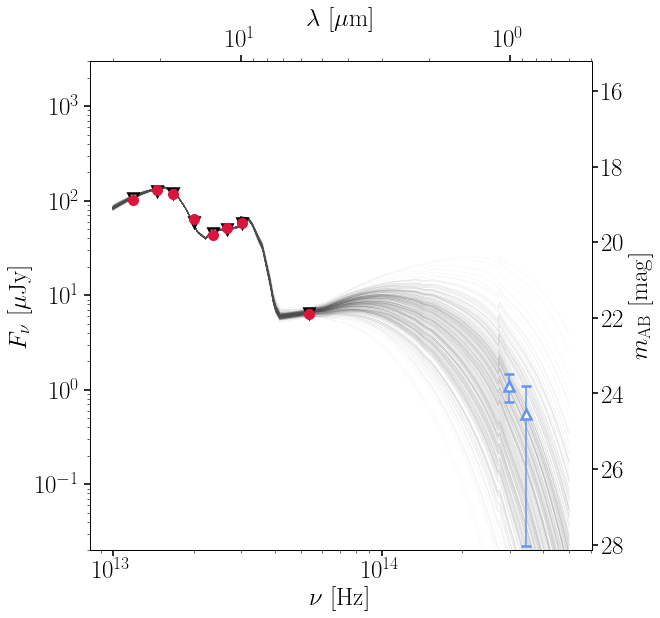

In [133]:
ax = plot_Fnu(trace_17eaw_Si_d_tau, Flam_17eaw,
              Flam_unc_17eaw, plot_prediction=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(2e-2, 3e3)

ax_mag = ax.twinx()
ax_mag.set_ylim(-2.5*np.log10(np.array(ax.get_ylim())*1e-6/3631))
ax_mag.set_ylabel(r'$m_\mathrm{AB}\ [\mathrm{mag}]$')
# ax_mag.axhline(22.1, color='orangered', linestyle='--')
# ax_mag.axhline(23.4, color='tan', linestyle='--')

ax_lam = ax.twiny()
ax_lam.set_xlim(2.99792458e10 / np.array(ax.get_xlim()) * 1e4)
ax_lam.set_xlabel(r'$\lambda\ [\mu\mathrm{m}]$')
ax_lam.set_xscale('log')

ax.get_legend().remove()

plt.savefig('17eaw_pred_tau.pdf', bbox_inches='tight')